# Fashion MNIST feedforward neural networks


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

## Preparing the Data

In [3]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor()) # Fashion MNIST 데이터셋 다운로드
test_dataset = FashionMNIST(root='data/', train=True, transform=ToTensor()) # Fashion MNIST 테스트 데이터셋 다운로드

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FashionMNIST\raw



In [ ]:
val_size = 10000 # validation set 크기
train_size = len(dataset) - val_size # training set 크기
train_ds, val_ds = random_split(dataset, [train_size, val_size]) # 전체 dataset으로부터 분리

print(list(train_ds))

In [4]:
batch_size=128 # batch 크기

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) # batch size만큼 training data 로드
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True) # batch size 2배만큼 validation data 로드
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True) # batch size 2배만큼 test data 로드

## Model

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # output 각 이미지마다 가장 큰 확률의 인덱스(=class 번호)를 변수 preds에 저장
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) # 분류가 잘된 개수로 정확도 산출

In [7]:
class MnistModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, 16) #hidden layer1을 통해 784 -> 16
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32) #hidden layer2를 통해 16 -> 32
        # output layer
        self.linear3 = nn.Linear(32, out_size) #output layer를 통해 32 -> 10
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        # hidden layer 1을 통해 중간값 산출
        out = self.linear1(out)
        # activation function으로 relu 적용
        out = F.relu(out)
        # hidden layer 2를 통해 중간값 산출
        out = self.linear2(out)
        # activation function으로 relu 적용
        out = F.relu(out)
        # output layer를 통해 예측값 산출
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # 예측값 생성
        loss = F.cross_entropy(out, labels) # loss 산출 (cross entropy 사용)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # 예측값 생성
        loss = F.cross_entropy(out, labels)   # loss 산출 (cross entropy 사용)
        acc = accuracy(out, labels)           # accuracy 산출
        return {'val_loss': loss, 'val_acc': acc}
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # 예측값 생성
        loss = F.cross_entropy(out, labels)   # loss 산출 (cross entropy 사용)
        acc = accuracy(out, labels)           # accuracy 산출
        return {'test_loss': loss, 'test_acc': acc}
        
    def test_pred(self, batch):
        images, labels = batch 
        out = self(images)                    # 예측값 생성
        _, preds = torch.max(out, dim=1)      # 변수 preds에 예측된 class 저장
        return preds
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # loss 결합
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # accuracy 결합
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # loss 결합
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # accuracy 결합
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

## Training the model

In [8]:
def evaluate1(model, val_loader): # validation set에 대한 모델 loss 및 accuracy 산출
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model, test_loader): # test set에 대한 모델 loss 및 accuracy 산출
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, test_loader, opt_func=torch.optim.SGD): # model 트레이닝 및 검증
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training 단계
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation 단계
        result1 = evaluate1(model, val_loader)
        # test 단계
        result2 = evaluate2(model, test_loader)
        history.append({**result1, **result2}) #epoch마다의 validation set과 test set에서의 loss, accuracy 누적
        
    return history

In [9]:
input_size = 784 # 28 * 28 pixel 데이터
num_classes = 10 # 총 클래스 라벨 개수

In [10]:
model = MnistModel(input_size, out_size=num_classes) # Neural Network 객체 생성

In [11]:
history = [{**evaluate1(model, val_loader), **evaluate2(model, test_loader)}] # validation set, test set의 loss와 accuracy 저장
history

[{'val_loss': 2.3075239658355713,
  'val_acc': 0.05654297024011612,
  'test_loss': 2.3057971000671387,
  'test_acc': 0.05332031100988388}]

In [12]:
history += fit(10, 0.1, model, train_loader, val_loader, test_loader) # training 후 loss, accuracy 변화 기록

In [13]:
history

[{'val_loss': 2.3075239658355713,
  'val_acc': 0.05654297024011612,
  'test_loss': 2.3057971000671387,
  'test_acc': 0.05332031100988388},
 {'val_loss': 0.5947979688644409,
  'val_acc': 0.7909179925918579,
  'test_loss': 0.605983555316925,
  'test_acc': 0.7789062261581421},
 {'val_loss': 0.594525933265686,
  'val_acc': 0.7821289300918579,
  'test_loss': 0.6110693216323853,
  'test_acc': 0.77587890625},
 {'val_loss': 0.4918852746486664,
  'val_acc': 0.8267577886581421,
  'test_loss': 0.5140551328659058,
  'test_acc': 0.815136730670929},
 {'val_loss': 0.460498183965683,
  'val_acc': 0.836621105670929,
  'test_loss': 0.47635895013809204,
  'test_acc': 0.828906238079071},
 {'val_loss': 0.4708684980869293,
  'val_acc': 0.830078125,
  'test_loss': 0.48562556505203247,
  'test_acc': 0.821093738079071},
 {'val_loss': 0.44264331459999084,
  'val_acc': 0.8446289300918579,
  'test_loss': 0.457392156124115,
  'test_acc': 0.8345702886581421},
 {'val_loss': 0.4077225625514984,
  'val_acc': 0.8579101

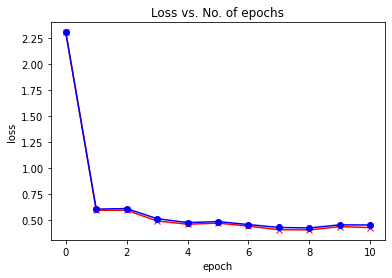

In [14]:
losses_val = [x['val_loss'] for x in history]
losses_test = [x['test_loss'] for x in history]
plt.plot(losses_val, 'r-x')
plt.plot(losses_test, 'b-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

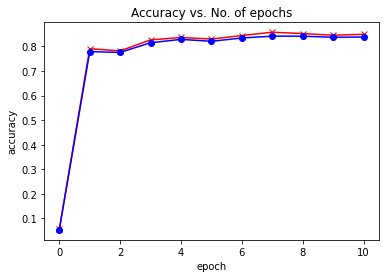

In [15]:
accuracies_val = [x['val_acc'] for x in history]
accuracies_test = [x['test_acc'] for x in history]
plt.plot(accuracies_val, 'r-x')
plt.plot(accuracies_test, 'b-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [16]:
evaluate2(model, test_loader) # test set에 대한 최종모델의 성능평가

{'test_loss': 0.4531128406524658, 'test_acc': 0.8384765386581421}

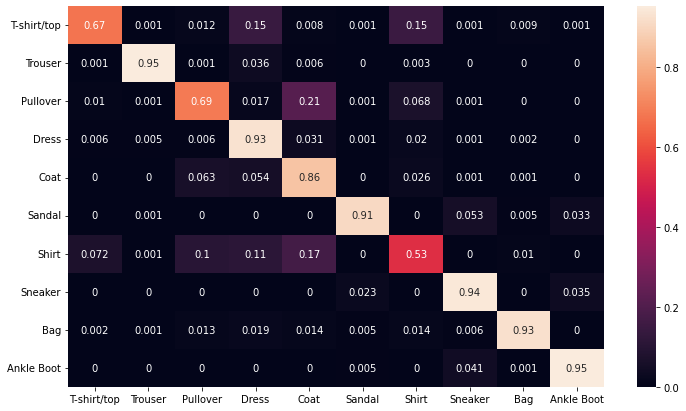

<Figure size 432x288 with 0 Axes>

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
for batch in test_loader:
    k = (model.test_pred(batch)).data.cpu().numpy().tolist()
    y_pred.append(k) # 예측값 저장
y_pred = sum(y_pred, [])
    
y_true = []
for inputs, labels in test_loader:   
    labels = labels.data.cpu().numpy().tolist()
    y_true.append(labels) # 실제값 저장
y_true = sum(y_true, [])
        
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# confusion matrix 생성
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()
plt.savefig('output_FNN1.png')